In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ellipse import *


In [2]:
def omegaY(theta):
    res = np.zeros((3,3),dtype=float)
    res[0,0] = np.cos(theta)
    res[0,2] = np.sin(theta)
    res[1,1] = 1
    res[2,0] = -np.sin(theta)
    res[2,2] = np.cos(theta)
    return res
def omegaZ(theta):
    res = np.zeros((3,3),dtype=float)
    res[0,0] = np.cos(theta)
    res[0,1] = -np.sin(theta)
    res[2,2] = 1
    res[1,0] = np.sin(theta)
    res[1,1] = np.cos(theta)
    return res
def construct_axes_from_main_axe(u,a,b):
    """
    Given an main ax for the ellipse : u
    we construct two other normalize orthogonal axes.
    The function returns all the three axes.
    b is the demi-small axe of the ellipse
    """
    if u[2]!=0:
        v = np.array([1,1,(-u[0]-u[1])/u[2]])
        w = np.array([u[1]*(-u[0]-u[1])/u[2]-u[2], 
                  u[2]-u[0]*(-u[0]-u[1])/u[2],
                 u[0]-u[1]])
    else:
        v = np.array([0,0,1])
        w = np.array([u[1],u[0],0])
    v = v/np.linalg.norm(v)*b
    w = w/np.linalg.norm(w)*b
    u = u*a
    if np.dot(u,v)>10**-10 :
        print("u,v not perpendicular")
        print("u.v = "+str(np.dot(u,v)))
    if np.dot(u,w)>10**-10 :
        print("u,v not perpendicular")
        print("u.v = "+str(np.dot(u,w)))
    if np.dot(w,v)>10**-10 :
        print("u,v not perpendicular")
        print("u.v = "+str(np.dot(w,v)))    
    return [u,v,w]
def ellipse_from_main_ax(main_ax,a,b,ctr):
    """
    ax 3 array/list with the coordinate of the main ax
    ctr is a 3D array/list with the coordinate of the center of mass
    a is the demi big ax
    b is the demi small ax (it is a rotationaly symetric ellipse)
    theta and phi are respectively the angle from the x axis and z
    axis minus Pi/2
    """
    # points on unit sphere
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    z = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    x = np.outer(np.ones_like(u), np.cos(v))
    #make sure that main_ax is normalized
    main_ax = main_ax/np.linalg.norm(main_ax)
    #compute theta and phi from the ax orientation:
    theta = np.arctan2(main_ax[1],main_ax[0])
    #compute the rotation matrix needed to rotate the elipse
    OmZ = omegaZ(theta)
    #phi = np.arctan2(main_ax[0],main_ax[2])-np.arccos(-1)/2
    phi = np.arctan2(np.sqrt(main_ax[0]**2+main_ax[1]**2),main_ax[2])-np.arccos(-1)/2
    print(theta,phi)
    OmY = omegaY(phi)
    #main_ax = np.dot(OmZ,main_ax)
    #create the two other normalize ax:
    axes = construct_axes_from_main_axe(np.array([1,0,0]),a,b)
    
    # transform points to ellipsoid
    for i in range(len(x)):
        for j in range(len(x)):
               x[i,j], y[i,j], z[i,j] = ctr + np.dot(OmZ,np.dot(OmY,np.dot(axes,
                                                      [x[i,j],y[i,j],z[i,j]])))
    return x,y,z
def is_point_in_ellipsoid(point, main_ax, a, b, ctr):
    # Normalize the main axis
    main_ax = main_ax / np.linalg.norm(main_ax)
    
    # Compute theta and phi from the main axis orientation
    theta = np.arctan2(main_ax[1], main_ax[0])
    phi = np.arctan2(np.sqrt(main_ax[0]**2 + main_ax[1]**2), main_ax[2]) - np.arccos(-1)/2
    
    # Inverse rotation matrices to align point with canonical ellipsoid axes
    OmZ_inv = omegaZ(-theta)  # Inverse rotation around Z-axis
    OmY_inv = omegaY(-phi)  # Inverse rotation around Y-axis
    
    # Transform the point to the ellipsoid's local coordinate system
    p_local = np.dot(OmY_inv, np.dot(OmZ_inv, point - ctr))
    
    # Check if the point is inside the ellipsoid using its canonical equation
    x, y, z = p_local
    return (x**2 / a**2) + (y**2 / b**2) + (z**2 / a**2) <= 1
def generate_point_in_ellipsoid(main_ax, ctr_mass, a, b, N_linker):
    n = np.linalg.norm(main_ax)
    if n != 0:
        main_ax = main_ax / n
    
    axes = construct_axes_from_main_axe(main_ax, a, b)

    theta = np.arctan2(main_ax[1], main_ax[0])
    OmZ = omegaZ(theta)
    
    phi = np.arctan2(np.sqrt(main_ax[0]**2 + main_ax[1]**2), main_ax[2]) - np.pi/2
    OmY = omegaY(phi)

    res = []

    for i in range(N_linker):
        phi = np.random.uniform(0, 2*np.pi)
        theta = np.arccos(np.random.uniform(-1, 1))
        r = np.random.uniform(0, 1) ** (1/3)

        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)

        point = np.dot(axes, [x, y, z])
        point = np.dot(OmY, point)
        point = np.dot(OmZ, point)
        point += ctr_mass

        res.append(point)

    return res

In [8]:

Omz = omegaZ(3.14/4.)
Omy = omegaY(3.14/4)
main_ax = np.dot(Omz,np.dot(Omy,np.array([10,0,0])))
ctr = [2,5,10]
points = np.array(generate_point_in_ellipsoid(main_ax, ctr, 10, 5, 1000))

x,y,z = ellipse_from_main_ax(main_ax,10,5,ctr)


0.7850000000000001 0.7850000000000001


In [26]:
isit = list()
for point in points:
    isit.append(is_point_in_ellipsoid(point, main_ax, 10, 5, ctr))


In [32]:
np.argwhere(np.asarray(isit)!=True)

array([], shape=(0, 1), dtype=int64)

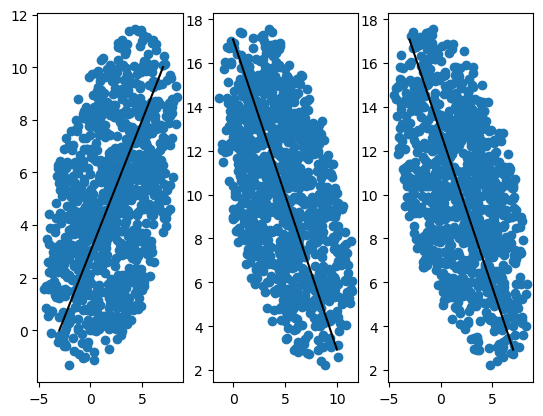

In [14]:
fig,ax = plt.subplots(ncols=3)
#ax[0].plot(x,y,color='black')
ax[0].plot([-main_ax[0]+ctr[0],main_ax[0]+ctr[0]],[-main_ax[1]+ctr[1],main_ax[1]+ctr[1]],color='black')
ax[0].scatter(points[:,0],points[:,1])

#ax[1].plot(y,z,color='black')
ax[1].plot([-main_ax[1]+ctr[1],main_ax[1]+ctr[1]],[-main_ax[2]+ctr[2],main_ax[2]+ctr[2]],color='black')
ax[1].scatter(points[:,1],points[:,2])

#ax[2].plot(y,z,color='black')
ax[2].plot([-main_ax[0]+ctr[0],main_ax[0]+ctr[0]],[-main_ax[2]+ctr[2],main_ax[2]+ctr[2]],color='black')
ax[2].scatter(points[:,0],points[:,2])

Text(0.5, 0, 'z')

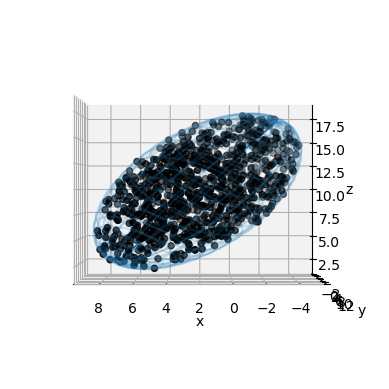

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2],color='black')
ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='#2980b9', alpha=0.2)
ax.plot([-main_ax[0]+ctr[0],main_ax[0]+ctr[0]],[-main_ax[1]+ctr[1],main_ax[1]+ctr[1]],[-main_ax[2]+ctr[2],main_ax[2]+ctr[2]])
#ax.plot([-second_ax[0],second_ax[0]],[-second_ax[1],second_ax[1]],[-second_ax[2],second_ax[2]])
#ax.plot([0,0],[-5,5],[0,0])
#ax.set_xlim(-10,10)
#ax.set_ylim(-10,10)
#ax.set_zlim(10,10)
ax.view_init(elev=0., azim=90)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

0.9547534927553428 0.5235985925389182


(-10.0, 10.0)

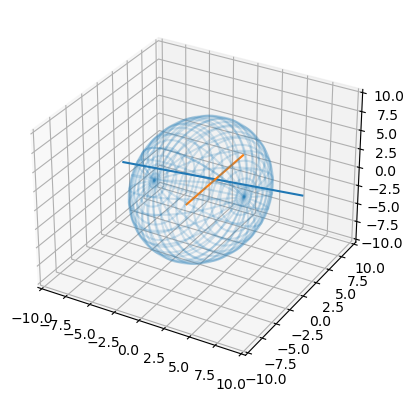

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
main_ax = np.dot(Omy,np.dot(Omz,[10,0,0]))
#print(np.dot(main_ax,second_ax))
x,y,z = ellipse_from_main_ax(main_ax,5,8,[0,0,0])
ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='#2980b9', alpha=0.2)
#ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='black', alpha=0.2)
ax.plot([-main_ax[0]+1,main_ax[0]+1],[-main_ax[1]+1,main_ax[1]+1],[-main_ax[2]+1,main_ax[2]+1])
#ax.plot([-second_ax[0]+1,1+second_ax[0]],[-second_ax[1]+1,second_ax[1]+1],[-second_ax[2]+1,second_ax[2]+1])
ax.plot([1,1],[-4,6],[1,1])
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)

In [16]:
np.sum(x[:,0])/x.shape[1]

3.80062839594482